# Visualization of the Search Methods

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/WoodOxen/tactics2d/blob/master/docs/tutorial/classical_planner_demo.ipynb)

This notebook demonstrates how to use the classical planners provided in Tactics2D, including Dijkstra, A*, Hybrid A*, D*, RRT, RRT*, MCT. First we will briefly introduce the planners, then we will show the use cases.

In [1]:
# If you are using colab, install the released version.
# %%capture
# !pip install tactics2d

In [2]:
# If you are running this notebook locally, use this block.
import os
import sys

sys.path.append(os.path.join(os.getcwd(), "../../"))

In [3]:
import numpy as np
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import LineString
from scipy.sparse import csr_matrix

from tactics2d.search import Dijkstra, RRT, RRTStar, MCTS
from tactics2d.map.generator import ParkingLotGenerator
from tactics2d.map.element import Map
from tactics2d.map.converter import Rasterization

# np.random.seed(42)
np.random.seed(33550336)

In [4]:
map_generator = ParkingLotGenerator()
map_ = Map()
start_state, target_area, target_heading = map_generator.generate(map_)
areas = map_.areas
obstacles = [area for area in areas.values() if area.type_ == "obstacle"]
bounds = map_.boundary
start = [start_state.x, start_state.y]
target = shapely.centroid(target_area.geometry)
target = [target.x, target.y]

## Performance without Consideration of Physics

In [5]:
def plot_path(path, tree=None):
    fig, ax = plt.subplots()
    ax.set_xlim(bounds[0], bounds[1])
    ax.set_ylim(bounds[2], bounds[3])

    for area in areas.values():
        ax.add_patch(
            Polygon(
                area.shape(outer_only=True),
                color="#424651" if area.type_ == "obstacle" else "#2CDA9D",
            )
        )

    if tree is not None:
        for node in tree:
            x, y, parent = node[:3]
            if parent is not None:
                px, py = tree[parent][:2]
                ax.plot([x, px], [y, py], linewidth=0.5, color="#E4C5AF")

    xs, ys = zip(*path)
    ax.plot(xs, ys, "-", linewidth=2, label="Final Path", color="#FE4A49")

    ax.plot(start[0], start[1], "o", markersize=8, label="Start", color="#07A0C3")
    ax.plot(target[0], target[1], "o", markersize=8, label="Target", color="#FE4A49")

    ax.legend(loc="upper right")
    plt.axis("equal")
    plt.show()

### Dijkstra

In [6]:
cell_size = 0.1
polygons = [obstacle.geometry for obstacle in obstacles]
rasterized_map = Rasterization.rasterize_polygons(polygons, bounds, cell_size)

In [7]:
h, w = rasterized_map.shape
N = h * w
edges = []
moves = [(1, 0), (-1, 0), (0, 1), (0, -1)]


def in_bounds(x, y):
    return 0 <= x < w and 0 <= y < h


for y in range(h):
    for x in range(w):
        if rasterized_map[y, x] == 1:
            continue
        idx = y * w + x
        for dx, dy in moves:
            nx, ny = x + dx, y + dy
            if in_bounds(nx, ny) and rasterized_map[ny, nx] == 0:
                nidx = ny * w + nx
                edges.append((idx, nidx, 1))

rows = [e[0] for e in edges]
cols = [e[1] for e in edges]
data = [e[2] for e in edges]
graph = csr_matrix((data, (rows, cols)), shape=(N, N))

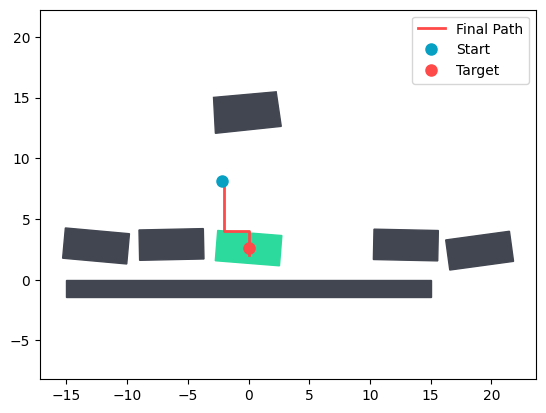

In [8]:
path = Dijkstra.plan(graph, cell_size, start, target, bounds)
plot_path(path)

### A*

### RRT and RRT*

In [9]:
def collide_fn(start, target, obstacles):
    line = LineString([start, target])
    for obstacle in obstacles:
        if line.intersects(obstacle.geometry):
            return True

    return False

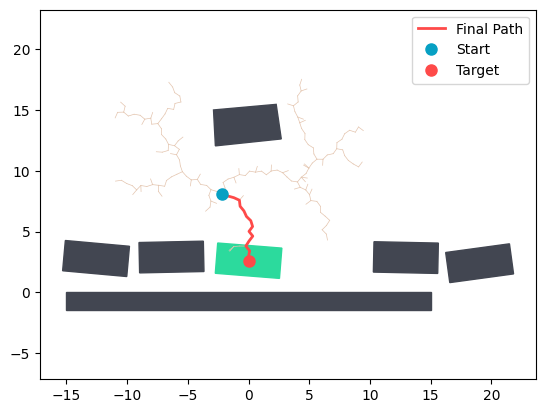

In [10]:
final_path, tree = RRT.plan(
    start, target, bounds, obstacles, collide_fn, max_iter=50000, step_size=cell_size * 5
)
plot_path(final_path, tree)

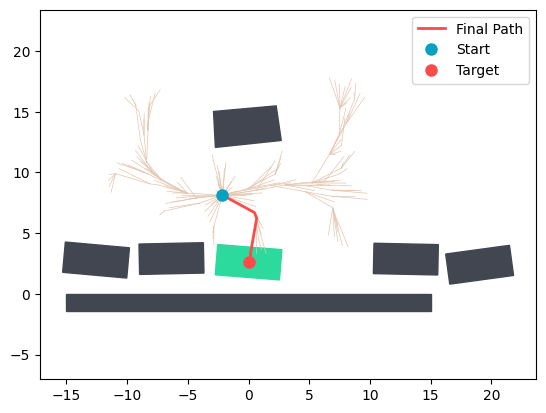

In [11]:
final_path, tree = RRTStar.plan(
    start,
    target,
    bounds,
    obstacles,
    collide_fn,
    max_iter=10000,
    step_size=cell_size * 5,
    radius=3.0,
)
plot_path(final_path, tree)